# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


## Исследовательский анализ данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [5]:
print('Размер выборки:', labels.shape)

Размер выборки: (7591, 2)


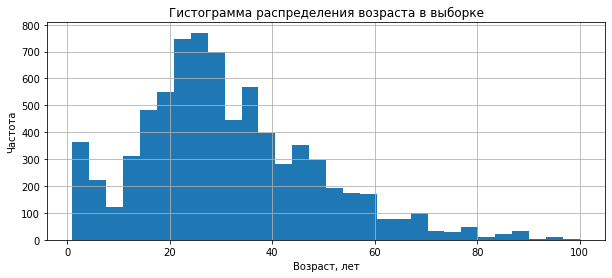

In [23]:
plt.figure(figsize=(10,4))
plt.hist(labels.real_age, bins=30)
plt.grid(True)
plt.title('Гистограмма распределения возраста в выборке')
plt.xlabel('Возраст, лет')
plt.ylabel('Частота')
plt.show()

Больше всего людей в выборке в возрасте 20-30 лет

In [33]:
train_gen_flow[0][0][0][0][0]

array([0.5764706, 0.5137255, 0.454902 ], dtype=float32)

Посмотрим теперь, из чего состоит наш датасет:

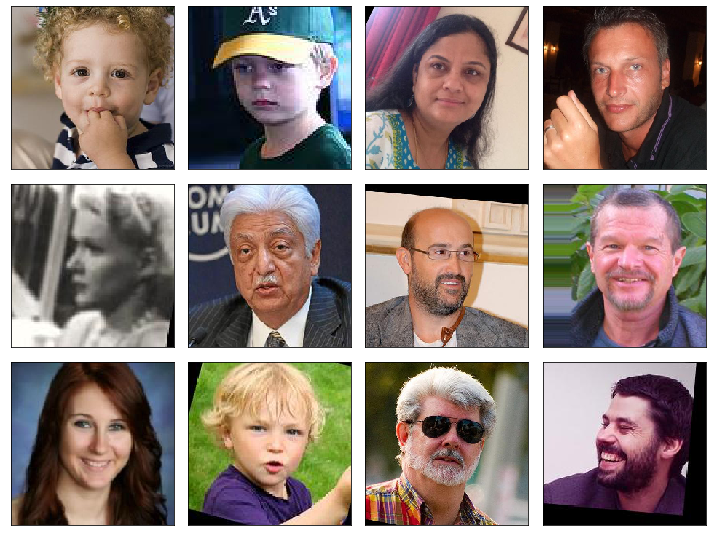

In [35]:
features, target = next(train_gen_flow)

# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Предварительный вывод:** Фотографии достоточно хорошего качества. Можно предположить, что модели удастся лучше определять возраст 20-30 лет, так как там сосредоточена большая часть фотографий. Определить точный возраст пожилого человека (старше 60 лет) будет проблематично. Фотографий этой категории крайне мало. С другой стороны, люди на фотографиях достаточно разные. Разные позы, эмоции, аксессуары, прически и так далее. На мой взгляд, размера датасета в 7951 фото недостаточно для высокого качества модели.

## Обучение модели

    def load_train(path):
        labels = pd.read_csv(path + 'labels.csv')
        datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
        train_gen_flow = datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=16,
            class_mode='raw',
            subset='training',
            seed=12345)

        return train_gen_flow


    def load_test(path):
        labels = pd.read_csv(path + 'labels.csv')
        datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
        test_gen_flow = datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=16,
            class_mode='raw',
            subset='validation',
            seed=12345)

        return test_gen_flow


    def create_model(input_shape):

        backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(1, activation='relu'))

        optimizer = Adam(lr=0.0001)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

        return model


    def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

        steps_per_epoch = len(train_data) if not steps_per_epoch else steps_per_epoch
        validation_steps = len(test_data) if not validation_steps else validation_steps

        model.fit(train_data,
                  validation_data=test_data,
                  batch_size=batch_size, epochs=epochs,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps,
                  verbose=2)

        return model


Результат обучения модели:

    Train for 356 steps, validate for 119 steps
    Epoch 1/10
    2021-07-07 06:55:12.443363: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
    2021-07-07 06:55:12.724008: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
    356/356 - 46s - loss: 200.6312 - mae: 10.3132 - val_loss: 821.2581 - val_mae: 23.6500
    Epoch 2/10
    356/356 - 38s - loss: 84.1298 - mae: 6.9690 - val_loss: 162.5826 - val_mae: 9.5448
    Epoch 3/10
    356/356 - 38s - loss: 59.2726 - mae: 5.8891 - val_loss: 77.7295 - val_mae: 6.5330
    Epoch 4/10
    356/356 - 38s - loss: 43.9201 - mae: 5.0882 - val_loss: 72.4101 - val_mae: 6.3252
    Epoch 5/10
    356/356 - 38s - loss: 32.0065 - mae: 4.3413 - val_loss: 69.4599 - val_mae: 6.1335
    Epoch 6/10
    356/356 - 38s - loss: 26.2386 - mae: 3.9208 - val_loss: 99.0897 - val_mae: 7.9113
    Epoch 7/10
    356/356 - 38s - loss: 21.7708 - mae: 3.5848 - val_loss: 74.2686 - val_mae: 6.4782
    Epoch 8/10
    356/356 - 38s - loss: 17.1745 - mae: 3.1583 - val_loss: 65.0336 - val_mae: 6.0452
    Epoch 9/10
    356/356 - 38s - loss: 15.2036 - mae: 2.9648 - val_loss: 90.7200 - val_mae: 7.1150
    Epoch 10/10
    356/356 - 38s - loss: 13.9746 - mae: 2.8635 - val_loss: 81.2398 - val_mae: 6.6594

## Анализ обученной модели

По результатам обучения нам удалось добиться MAE = 6.65. Это значит, что модель ошибается в среднем на 6.5 лет в определении возраста. Что подтверждает результаты статьи

Смею предположить, что такого качества недостаточно для применения модели в качестве детектора несовершеннолетних граждан. Однако, мы можем увеличить буферную зону, т.е. поднять возрастную категорию граждан, которым необходимо предъявить паспорт с 18 лет до 25 лет. Тем самым мы увеличим Recall, что сделает модель гораздо более эффективной.

Полученная модель так же подойдет в качестве инструмента грубой сегментации покупателей по возрасту.